# Textual Variation Analysis for 'Conditions' Columns

This analysis builds upon ealier iterations using [textAnalysis.py](https://github.com/UCSB-AMPLab/sondondo/blob/e3d7781/project_code/textAnalysis.py) and [textualAnalysis.py](https://github.com/UCSB-AMPLab/sondondo/blob/6fd3812/project_code/textualAnalysis.py) which led to the creation of the current [conditionMapping.json](https://github.com/UCSB-AMPLab/sondondo/blob/c200723/data/mappings/conditionMapping.json).

The goal of this analysis is to examine textual variation and overlapping categories within the "conditions" columns across the cleaned datasets (`data/clean/bautismos_clean.csv`, `data/clean/matrimonios_clean.csv`, and `data/clean/defunciones_clean.csv`). This helps to evaluate how a reduced and harmonized mapping contributes to a more consistent and maneageable classification scheme.


## Strategy for Creating `conditionMapping.json`

The main objective was to reduce textual variation in the "conditions" columns without inadvertently losing important information. The process involved the following steps:

1. Define three main categories of "conditions":
   - Legitimacy status: Wheter the child was born within a legitimate marriage.
   - Marital status: Wheter a persona was married, divorced, or widowed at the time of the event.
   - Social condition: Labels used by the authority recording the event to mark social origin or perceived status (e.g., "indigena", "mestizo").
2. Run TF-IDF analysis across all "conditions" columns from the raw datasets to identify the most frequent and distinctive keywords in each group.
   - Results can be found in [main@e3d7781/logs/textanalysis.log](https://github.com/UCSB-AMPLab/sondondo/blob/e3d7781/logs/textanalysis.log)
3.  Manually curate mapping from the top-ranked terms for each category. The following criteria guided the normalization process:
    - Remove diacritics and accents.
    - Convert all gendered terms to their masculine form.
    - Use singular rather than plural forms.
    - Expand abbreviations to full terms.
    - Consolidate synonyms into the most commonly used or historically accurate term, e.g., "natural" mapped to "indio".

## Set the Project

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import json

from utils.LoggerHandler import setup_logger

logger = setup_logger("termExtraction")

In [2]:
dataframes_paths = {
    "bautismos": {
        "csv_file": "../data/clean/bautismos_clean.csv"
    },
    "entierros": {
        "csv_file": "../data/clean/entierros_clean.csv"
    },
    "matrimonios": {
        "csv_file": "../data/clean/matrimonios_clean.csv"
    }
}

with open('../data/mappings/conditionMapping.json', 'r', encoding='utf-8') as f:
    condition_mappings = json.load(f)

existing_mappings = {
    "legitimacy_status": list(condition_mappings["attribute_mappings"]["legitimacy_status"].keys()),
    "social_condition": list(condition_mappings["attribute_mappings"]["social_condition"].keys()),
    "marital_status": list(condition_mappings["attribute_mappings"]["marital_status"].keys())
}


## Statistical Analysis

To accurately assess the effectiveness of the mapping, we performed a series of statistical analyses on the cleaned datasets. 


### Textual Variation Extraction

These methods extract textual variations from the "conditions" columns using a regex pattern that matches the defined categories. 

In [3]:
def extract_textual_variations_from_columns(column_pattern, min_frequency: int = 1) -> dict:
    """
    Extract all textual variations from columns matching a pattern.
    This reveals how conditions were expressed in historical documents,
    including mixed categories (e.g., marital status + age descriptors).
    
    Args:
        column_pattern: Regex pattern to match column names
        min_frequency: Minimum frequency for a term to be included
        
    Returns:
        Dictionary with term frequencies and contextual metadata
    """
    term_data = {}

    for dataset, info in dataframes_paths.items():
        logger.info(f"Extracting textual variations from {dataset}...")
        csv_path = info["csv_file"]

        df = pd.read_csv(csv_path)

        # Find matching columns
        if isinstance(column_pattern, str):
            pattern = re.compile(column_pattern)
        else:
            pattern = column_pattern
            
        matching_columns = [col for col in df.columns if pattern.search(col)]
        logger.info(f"Columns found: {matching_columns}")

        if not matching_columns:
            continue
        
        # Extract all textual variations
        for col in matching_columns:
            logger.info(f"Processing column: {col}")
            
            # basic preprocessing
            values = df[col].dropna().astype(str)
            values = values[values != 'nan']
            values = values[values.str.strip() != '']
            
            cleaned_values = values.str.lower().str.strip()

            logger.info(f"Found {len(cleaned_values)} non-empty entries")

            # Count occurrences
            value_counts = cleaned_values.value_counts()
            
            for term, count in value_counts.items():
                if term not in term_data:
                    term_data[term] = {
                        'frequency': 0, 
                        'columns': set(), 
                        'datasets': set(),
                        'raw_variations': set()
                    }
                
                term_data[term]['frequency'] += count
                term_data[term]['columns'].add(col)
                term_data[term]['datasets'].add(dataset)
                
                original_values = values[cleaned_values == term]
                term_data[term]['raw_variations'].update(original_values.tolist())

    # Filter by frequency
    filtered_terms = {}
    for term, data in term_data.items():
        if data['frequency'] >= min_frequency:
            filtered_terms[term] = {
                'frequency': data['frequency'],
                'columns': list(data['columns']),
                'datasets': list(data['datasets']),
                'raw_variations': list(data['raw_variations'])
            }
    
    return filtered_terms

In [4]:
# Categories Data

legitimacy_variations = extract_textual_variations_from_columns(
    column_pattern=re.compile(r".*legitimacy_status.*"),
    min_frequency=1
)

social_variations = extract_textual_variations_from_columns(
    column_pattern=re.compile(r".*social_condition.*"),
    min_frequency=1
)

marital_variations = extract_textual_variations_from_columns(
    column_pattern=re.compile(r".*marital_status.*"),
    min_frequency=1
)


In [5]:
categories_data = {
    'legitimacy_status': (legitimacy_variations, existing_mappings["legitimacy_status"]),
    'social_condition': (social_variations, existing_mappings["social_condition"]),
    'marital_status': (marital_variations, existing_mappings["marital_status"])
}

### Results of the Exploratory Analysis

We performed a frequency count of the terms found in the "conditions" columns, grouping them by their main categories. The following results summarize the number of unique terms and their total frequency of appearance in the dataset:

In [6]:
stats = {}

for category, (terms_dict, mappings) in categories_data.items():
    frequencies = [info['frequency'] for info in terms_dict.values()]
    stats[category] = {
        'frequencies': frequencies,
        'total_terms': len(frequencies),
        'total_frequency': sum(frequencies)
    }

stats_df = pd.DataFrame(stats).T.sort_values(by='total_frequency', ascending=False).reset_index().rename(columns={'index': 'category'})
stats_df

,category,frequencies,total_terms,total_frequency
0,legitimacy_status,"[996, 917, 1495, 1366, 521, 428, 383, 350, 118...",314,10265
1,social_condition,"[1382, 332, 29, 14, 18, 8, 33, 10, 71, 6, 6, 6...",955,9249
2,marital_status,"[400, 247, 406, 1389, 1321, 368, 24, 24, 18, 1...",34,4254


The data shows that the social condition category has the highest number of unique terms (955), despite having a lower total frequency than legitimacy status. This suggests that many of the terms under social condition appear only once or a few times, indicating high textual variation and inconsistency — likely due to diverse wording choices by different scribes over time, as well as inconsistencies introduced during transcription.

In contrast, the marital status category is significantly more standardized, with only 34 unique terms used across 4,254 entries. This low variation points to a more consistent vocabulary and higher likelihood of successful harmonization.

To further quantify this, we computed the average frequency per term, which helps identify how often terms are reused — a proxy for redundancy and consistency.

In [7]:
stats_df['avg_frequency_per_term'] = stats_df['total_frequency'] / stats_df['total_terms']
stats_df['avg_frequency_per_term'] = stats_df['avg_frequency_per_term'].astype(float).round(2)
stats_df

,category,frequencies,total_terms,total_frequency,avg_frequency_per_term
0,legitimacy_status,"[996, 917, 1495, 1366, 521, 428, 383, 350, 118...",314,10265,32.69
1,social_condition,"[1382, 332, 29, 14, 18, 8, 33, 10, 71, 6, 6, 6...",955,9249,9.68
2,marital_status,"[400, 247, 406, 1389, 1321, 368, 24, 24, 18, 1...",34,4254,125.12


As shown above:

- Social condition has the lowest average frequency per term (~9.7), confirming high fragmentation and the presence of long-tail entries that may be semantically similar but textually distinct.

- Marital status has the highest reuse rate (~125 per term), suggesting a more constrained vocabulary and consistent usage patterns.

- Legitimacy status sits in between, with moderate variation and moderate reuse.

While all three categories benefit from textual normalization, social condition stands out as requiring special attention. Its high number of unique, low-frequency terms suggests significant noise and ambiguity that can hinder downstream analysis unless harmonized. The average frequency metric supports this interpretation and can serve as a quantifiable justification for the harmonization strategy applied in subsequent steps.

### **Coefficient of Variation**: 

The coefficient of variation (CV) measures how much variability exists relative to the average value. In our case, we compute the CV across parishes based on the number of unique "conditions" entries before and after applying the mapping. A lower CV after mapping indicates that the mapping has reduced variation in the use of terms across parishes, suggesting improved consistency.

In [8]:
from utils import StatsMethods

In [9]:
stats_df['cv'] = stats_df.apply(lambda row: StatsMethods.cv(row['frequencies'], rounding=2), axis=1)
stats_df

,category,frequencies,total_terms,total_frequency,avg_frequency_per_term,cv
0,legitimacy_status,"[996, 917, 1495, 1366, 521, 428, 383, 350, 118...",314,10265,32.69,4.96
1,social_condition,"[1382, 332, 29, 14, 18, 8, 33, 10, 71, 6, 6, 6...",955,9249,9.68,5.66
2,marital_status,"[400, 247, 406, 1389, 1321, 368, 24, 24, 18, 1...",34,4254,125.12,2.66


### Shannon Entropy

Shannon entropy quantifies the uncertainty or randomness in a set of data. We can notice that social condition has the highest entropy (H) and normalized entropy (Normalized_H), showing again the level of fragmentation of this group. Legitimacy and marital status have lower levels, but we expect that the mapping will reduce their entropy as well, leading to more consistent usage patterns.

In [10]:
stats_df[['H', 'H_max', 'Normalized_H', 'Redundancy']] = stats_df.apply(
    lambda row: StatsMethods.shannon_entropy(row['frequencies'], rounding=2),
    axis=1, result_type='expand'
)
stats_df[['cv', 'H', 'H_max', 'Normalized_H', 'Redundancy']]

,cv,H,H_max,Normalized_H,Redundancy
0,4.96,4.43,8.29,0.53,0.47
1,5.66,6.97,9.90,0.70,0.30
2,2.66,2.50,5.09,0.49,0.51


### Zipf Distribution

Zipf's law describes the frequency of terms in a language, where a few terms are very common while many others are rare. We can visualize the distribution of term frequencies to see if they follow this pattern. A Zipfian distribution would indicate that a small number of terms dominate usage, while many others are used infrequently.

In [11]:
stats_df['zipf_distribution'] = stats_df.apply(
    lambda row: StatsMethods.zipf_distribution(row['frequencies'], rounding=2),
    axis=1
)
stats_df[['cv', 'H', 'H_max', 'Normalized_H', 'Redundancy', 'zipf_distribution']]

,cv,H,H_max,Normalized_H,Redundancy,zipf_distribution
0,4.96,4.43,8.29,0.53,0.47,"[0.16, 0.08, 0.05, 0.04, 0.03, 0.03, 0.02, 0.0..."
1,5.66,6.97,9.90,0.70,0.30,"[0.13, 0.07, 0.04, 0.03, 0.03, 0.02, 0.02, 0.0..."
2,2.66,2.50,5.09,0.49,0.51,"[0.24, 0.12, 0.08, 0.06, 0.05, 0.04, 0.03, 0.0..."


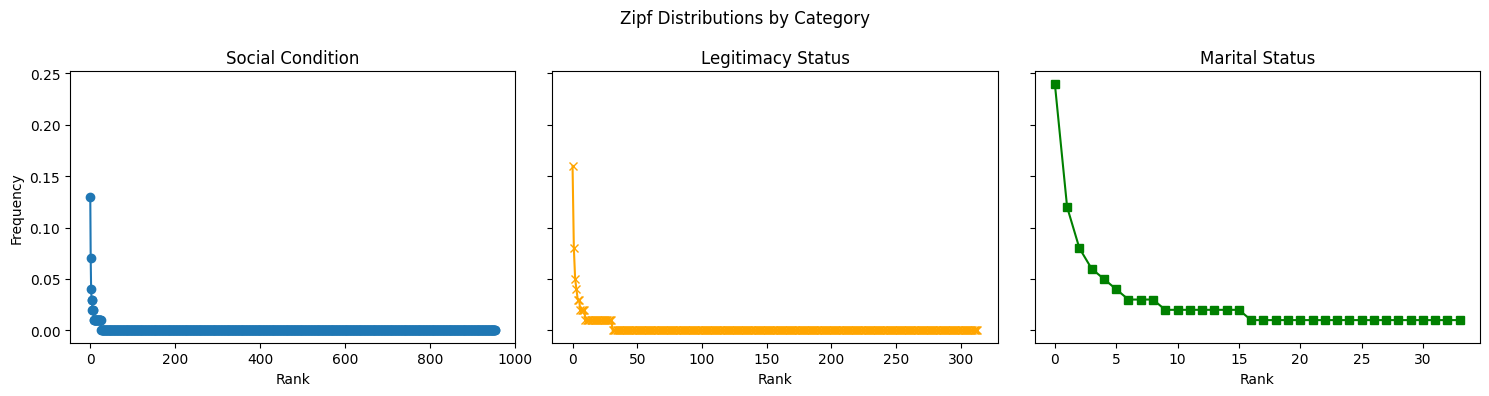

In [19]:
social_status_zipf = stats_df.loc[stats_df['category'] == 'social_condition']['zipf_distribution'].iloc[0]
legitimacy_status_zipf = stats_df.loc[stats_df['category'] == 'legitimacy_status']['zipf_distribution'].iloc[0]
marital_status_zipf = stats_df.loc[stats_df['category'] == 'marital_status']['zipf_distribution'].iloc[0]


fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# Social condition
axes[0].plot(social_status_zipf, marker='o')
axes[0].set_title("Social Condition")
axes[0].set_xlabel("Rank")
axes[0].set_ylabel("Frequency")

# Legitimacy status
axes[1].plot(legitimacy_status_zipf, marker='x', color='orange')
axes[1].set_title("Legitimacy Status")
axes[1].set_xlabel("Rank")

# Marital status
axes[2].plot(marital_status_zipf, marker='s', color='green')
axes[2].set_title("Marital Status")
axes[2].set_xlabel("Rank")

plt.suptitle("Zipf Distributions by Category")
plt.tight_layout()
plt.show()



## Normalization

Our normalization strategy is designed to address the textual variation, redundancy, high entropy, and category mixing present in the “conditions” columns. The label “condition” was ambiguous even for parish priests and local officials, leading to inconsistent application across records. Without a standardized vocabulary or a consistent method for disambiguating terms, social, marital, and legitimacy-related descriptors appear intermingled in the same fields.

To resolve this, we developed the `InferCondition.py` module, which can extract specific attributes from any “conditions” column, regardless of the category in which they were recorded. For example, `extract_marital_status` can be applied to a `social_condition` column to recover marital status terms that were incorrectly placed there. When applied to the correct category, these extractors significantly reduce variability.

At its core, the module implements the AttributeNormalizer class, which:

- Loads predefined mapping dictionaries for social condition, legitimacy status, and marital status.
- Applies a multi-stage harmonization process:
    - Case-insensitive exact match (checks if the term already matches a target form).
    - Word-level match (matches any single token to the mapping).
    - Substring match (captures longer phrases containing mapped terms).
    - Fuzzy match (using RapidFuzz with a configurable threshold).
- Logs unmapped values for later review.
- Provides convenience methods to extract all attributes from a column or harmonize multiple columns in one pass.
- Includes a function to extract unmapped tokens, removing all known mapped values and leaving residual, potentially meaningful text for further analysis.

This normalization is a foundational step in preparing the dataset for probabilistic record linkage, as it reduces noise, improves consistency, and aligns variant expressions to a controlled vocabulary without discarding historically meaningful distinctions.